In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


The df is pretty clean, hence does not need preprocessing

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


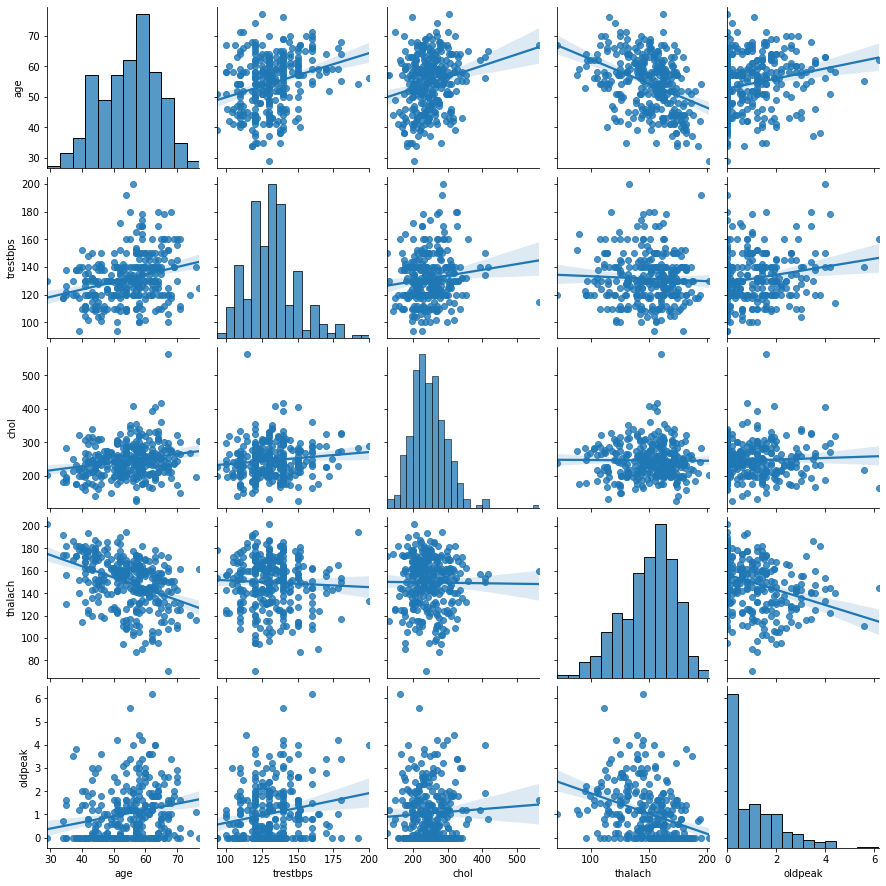

In [5]:
sns.pairplot(df[['age','trestbps','chol','thalach','oldpeak']], kind='reg');

Variables do not look correlated

Having a look to the distribution of each feature in respect to the target variable

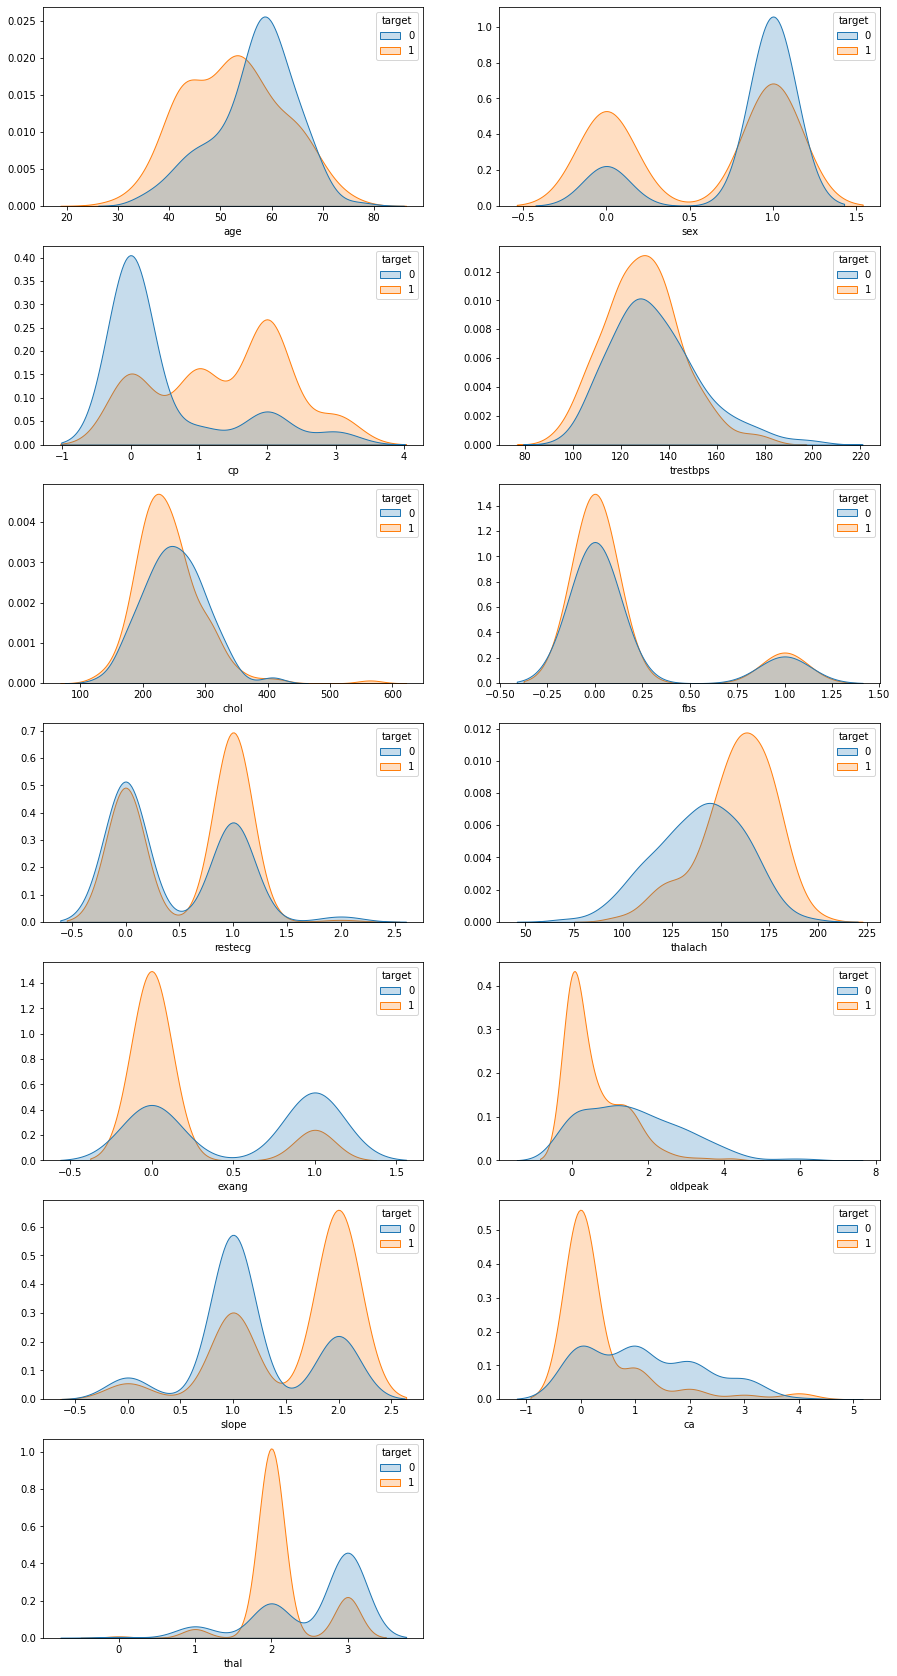

In [6]:
fig, axes = plt.subplots(7, 2, figsize = (15,30))
for ax, col in zip(axes.flatten(), df.drop('target',axis=1).columns):
    sns.kdeplot(data=df, x=col, hue='target', shade=True, ax = ax)
    ax.set_ylabel(None)

fig.delaxes(axes[6][1])   #removes blank graph
plt.show() 

In [7]:
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

The dataset is quite balanced, hence does not need resampling techniques

Importing useful libraries. Note I used some custom functionality imported from func.py

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score
from func import PearsonSelector, MinMaxScalerCust, RobustScalerCust, StandardScalerCust, CustomEstimator, get_fitted_pipe, get_results

Splitting the dataset into train and test set

In [9]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 15)

Defining a param grid with both estimators and associated parameters to feed the pipelines with

In [10]:
params = [{'model': [LogisticRegression()],
                    'model__C': [1,5,10,20,100],
                    'model__max_iter': [300,350]},
          
          {'model': [KNeighborsClassifier()],
                    'model__n_neighbors': [i for i in range (5,11)],
                    'model__algorithm': ['auto', 'brute']},
          
          {'model': [DecisionTreeClassifier()],
                    'model__criterion': ['gini', 'entropy'],
                    'model__min_samples_leaf': [i for i in range(1,6)],
                    'model__max_depth': [i for i in range(1,6)]},
          
          {'model': [RandomForestClassifier()],
                    'model__n_estimators': [300, 400],
                    'model__max_depth': [i for i in range(1,6)]},
          
          {'model': [xgb.XGBClassifier()],
                    'model__n_estimators': [100,1000]},   
          ]


Defining the pipelines I am willing to use. Note that CustomEstimator simply acts as a placeholder for the estimators in the grid above. The goal is performing hyperparameter tuning and selecting the best pipeline with the best algorithm altogether.

In [11]:
pipe_1 = Pipeline([('pearsonselector', PearsonSelector()), ('scaler', StandardScalerCust()), ('pca', PCA(n_components=3)), ('model', CustomEstimator())])
pipe_2 = Pipeline([('scaler', MinMaxScalerCust()),('rfe',RFE(LogisticRegression(max_iter=500))), ('model', CustomEstimator())])
pipe_3 = Pipeline([('scaler', RobustScalerCust()),('selector', SelectFromModel(estimator=LassoCV())), ('model', CustomEstimator())])
pipe_4 = Pipeline([('selector', SelectKBest(chi2, k = 3)), ('model', CustomEstimator())])

Collecting pipes and params in a dictionary

In [12]:
pipe_dict = {}
pipe_dict['pipe_1'] = [pipe_1, params]
pipe_dict['pipe_2'] = [pipe_2, params]
pipe_dict['pipe_3'] = [pipe_3, params]
pipe_dict['pipe_4'] = [pipe_4, params]

In [ ]:
fitted_pipes = get_fitted_pipe(pipe_dict, X_train, X_test, y_train)

Exploring results

In [14]:
get_results(fitted_pipes, X_test, y_test).T

,AUC,Precision,Recall,F1,Avg Precision
pipe_1,0.897186,0.806452,0.757576,0.781250,0.910131
pipe_2,0.919913,0.888889,0.727273,0.800000,0.940680
pipe_3,0.920996,0.892857,0.757576,0.819672,0.941764
pipe_4,0.894481,0.843750,0.818182,0.830769,0.877391


In [15]:
for name, pipe in fitted_pipes.items():
    print(str(name) +": " + str(pipe.best_params_))

pipe_1: {'model': LogisticRegression(C=5, max_iter=300), 'model__C': 5, 'model__max_iter': 300}
pipe_2: {'model': RandomForestClassifier(max_depth=1, n_estimators=300), 'model__max_depth': 4, 'model__n_estimators': 400}
pipe_3: {'model': RandomForestClassifier(max_depth=1, n_estimators=300), 'model__max_depth': 5, 'model__n_estimators': 300}
pipe_4: {'model': RandomForestClassifier(max_depth=1, n_estimators=300), 'model__max_depth': 1, 'model__n_estimators': 300}


### Conclusion

Looks like RandomForest is the best algorithm according to almost all pipelines. Among these ones, pipe_3 (robust scaling + feature selection based on Lasso) obtained the best AUC and Average precision results